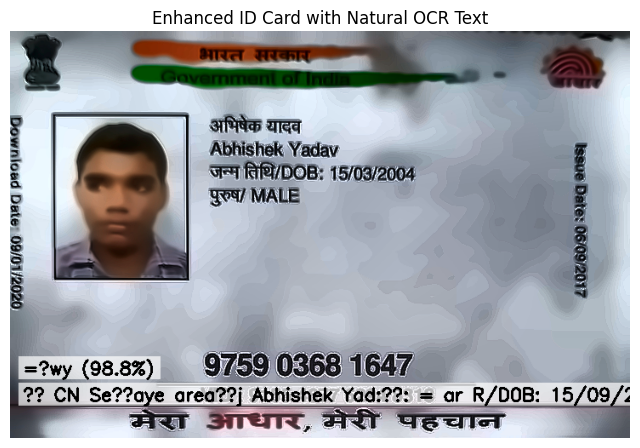

In [23]:
import os
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path

# Set Tesseract path (update this based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define input directory
input_folder = Path("input")
input_folder.mkdir(exist_ok=True)

# Function to preprocess image for Faster R-CNN
def preprocess_image(image_path):
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).unsqueeze(0)  # Add batch dimension
    return img, img_rgb, img_tensor

# Function to enhance image dynamically
def enhance_image(image, denoise_h=10, clahe_clip=3.0):
    # Noise reduction with non-local means denoising
    denoised = cv2.fastNlMeansDenoisingColored(image, h=denoise_h, hColor=denoise_h, templateWindowSize=7, searchWindowSize=21)
    
    # Deblur using Gaussian blur and sharpening
    blurred = cv2.GaussianBlur(denoised, (5, 5), 0)
    sharpened = cv2.addWeighted(denoised, 1.5, blurred, -0.5, 0)
    
    # Contrast adjustment using CLAHE
    lab = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=(4, 4))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return enhanced

# Function to correct skew and align the ID card
def correct_skew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        for rho, theta in lines[0]:
            angle = (theta * 180 / np.pi) - 90
            break
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# Function to detect ROIs with Faster R-CNN
def detect_rois(model, img_tensor, threshold=0.5):
    with torch.no_grad():
        predictions = model(img_tensor)[0]
    boxes = predictions['boxes'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    mask = scores > threshold
    return boxes[mask], scores[mask], labels[mask]

# Function to extract text from ROIs using OCR with preprocessing
def extract_text_from_roi(image, box):
    x1, y1, x2, y2 = map(int, box)
    roi = image[y1:y2, x1:x2]
    # Preprocess ROI for better OCR
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    text = pytesseract.image_to_string(thresh, config='--psm 6')
    return text.strip()

# Function to crop the ID card from the image
def crop_id_card(image, boxes):
    if len(boxes) == 0:
        return image
    largest_box = max(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]))
    x1, y1, x2, y2 = map(int, largest_box)
    cropped = image[y1:y2, x1:x2]
    return cropped

# Function to find a suitable text placement region (e.g., bottom of the ID card)
def find_text_placement_region(image):
    h, w = image.shape[:2]
    # Assume bottom 20% of the image is a good spot for text (adjustable)
    return h - int(h * 0.2), h, 0, w

# Main processing function to display enhanced ID card with naturally integrated OCR text
def process_and_display_id_card(image_path):
    # Load and preprocess image
    original_img, img_rgb, img_tensor = preprocess_image(image_path)

    # Enhance and align the image
    enhanced_img = enhance_image(original_img)
    enhanced_img = correct_skew(enhanced_img)

    # Detect ROIs
    _, enhanced_rgb, enhanced_tensor = preprocess_image(image_path)
    boxes, scores, labels = detect_rois(model, enhanced_tensor)

    # Extract text from ROIs
    ocr_results = []
    for i, box in enumerate(boxes[:5]):  # Limit to top 5 ROIs
        text = extract_text_from_roi(enhanced_img, box)
        confidence = scores[i] * 100
        if text:
            ocr_results.append(f"{text} ({confidence:.1f}%)")

    # Crop the ID card
    cropped_id = crop_id_card(enhanced_img, boxes)
    cropped_id = enhance_image(cropped_id)  # Re-enhance for best quality

    # Find placement region for text (bottom of the ID card)
    y_start, y_end, x_start, x_end = find_text_placement_region(cropped_id)
    output_img = cropped_id.copy()

    # Overlay OCR text naturally on the ID card
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 2
    text_color = (0, 0, 0)  # Black text for readability
    bg_color = (255, 255, 255, 50)  # Semi-transparent white background

    y_offset = y_start + 20
    for result in ocr_results:
        # Calculate text size
        (text_w, text_h), baseline = cv2.getTextSize(result, font, font_scale, font_thickness)
        
        # Draw a semi-transparent background rectangle for contrast
        bg_x, bg_y = 10, y_offset - text_h - 5
        bg_w, bg_h = text_w + 10, text_h + 10
        overlay = output_img.copy()
        cv2.rectangle(overlay, (bg_x, bg_y), (bg_x + bg_w, bg_y + bg_h), bg_color[:3], -1)
        cv2.addWeighted(overlay, 0.7, output_img, 0.3, 0, output_img)
        
        # Add text
        cv2.putText(output_img, result, (bg_x + 5, y_offset), font, font_scale, text_color, font_thickness)
        y_offset += text_h + 15

        # Stop if we exceed the image height
        if y_offset + text_h > output_img.shape[0]:
            break

    # Display the resultA
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Enhanced ID Card with Natural OCR Text")
    plt.show()

# Process the first image in the input folder
image_files = list(input_folder.glob("*.jpg"))
if image_files:
    process_and_display_id_card(image_files[0])
else:
    print("No images found in the 'input' folder. Please add an ID card image (e.g., 'id_card.jpg').")